# Evaluation of HBDScan Clustering for Individual Model

Imports and Constants

**Part 1:** Loading Model

**Part 2:** Creating UMAP Projection of Model

**Part 3:** Creating Heatmap of Clustering Hyperparameters

**Part 4:** Creating Plot of Different Clusters


In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import umap
import matplotlib.pyplot as plt
import hdbscan
from collections import Counter
import s_dbw
import dbcv

In [2]:
MIN_CLUSTER_RANGE = range(2, 12)
MIN_SAMPLE_RANGE = range(2, 12)

RESNET_VERSION = 50
LATENT_SPACE_DIM = 3
WINDOW_SIZE = 1
TRAINING_STEPS = 90
TRAIN_TEST_SPLIT = 0.1
LINE_WIDTH = 1

SEED = 42
np.random.seed(SEED)

## Part 1: Loading Model

In [3]:
path = Path("../explorer/fingerprints")
model = f"resnet{RESNET_VERSION}_latent{LATENT_SPACE_DIM}_window{WINDOW_SIZE}eV_steps{TRAINING_STEPS}_split{TRAIN_TEST_SPLIT * 10}_width{LINE_WIDTH}_.csv"
model_path = path / model

csv = pd.read_csv(model_path)

features = csv.filter(like="z").to_numpy()

## Part 2: Creating UMAP Projection of Model

/home/justin/miniconda3/envs/myenv/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


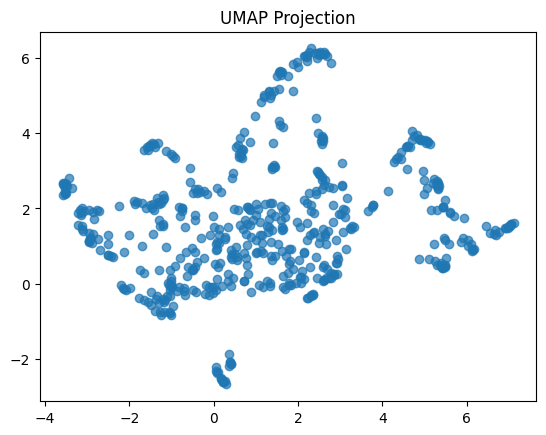

In [4]:
reducer = reducer = umap.UMAP(
    n_neighbors = 10,
    min_dist    = 0.1,
    metric      = "minkowski",   # should match what yielded good clusters
    random_state = 42
)

embedding = reducer.fit_transform(features)

emb = embedding
plt.scatter(emb[:,0], emb[:,1], alpha=0.7)
plt.title("UMAP Projection")
plt.show()

# Part 3: Creating Heatmap of Clustering Hyperparameters

In [5]:
num_unclustered_arr = np.zeros([len(MIN_CLUSTER_RANGE), len(MIN_SAMPLE_RANGE)])
num_clusters_arr = np.zeros([len(MIN_CLUSTER_RANGE), len(MIN_SAMPLE_RANGE)])
dbcv_arr = np.zeros([len(MIN_CLUSTER_RANGE), len(MIN_SAMPLE_RANGE)])
s_dbw_arr = np.zeros([len(MIN_CLUSTER_RANGE), len(MIN_SAMPLE_RANGE)])
sd_arr = np.zeros([len(MIN_CLUSTER_RANGE), len(MIN_SAMPLE_RANGE)])

for i, cluster_size in enumerate(MIN_CLUSTER_RANGE):
    for j, sample_min in enumerate(MIN_SAMPLE_RANGE):
        clusterer = hdbscan.HDBSCAN(algorithm='best', alpha=1.0, approx_min_span_tree=True,
                                gen_min_span_tree=True, leaf_size=40, metric='minkowski', 
                                cluster_selection_method='leaf', min_cluster_size=cluster_size, min_samples=sample_min, p=0.2)
        
        labels = clusterer.fit_predict(features)

        num_unclustered_arr[i][j] = Counter(labels)[-1]
        num_clusters_arr[i][j] = len(Counter(labels)) - 1

        if num_clusters_arr[i][j] == 0:
            s_dbw_arr[i][j] = np.inf
            sd_arr[i][j] = np.inf

        else:
            s_dbw_arr[i][j] =  s_dbw.S_Dbw(features, labels)
            sd_arr[i][j] = s_dbw.SD(features, labels)


        dbcv_arr[i][j] = dbcv.dbcv(features, labels)
        

/home/justin/miniconda3/envs/myenv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/justin/miniconda3/envs/myenv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/justin/miniconda3/envs/myenv/lib/python3.13/site-packages/dbcv/core.py:91: RuntimeWarning: divide by zero encountered in power
  np.power(core_dists, -1.0 / d, out=core_dists)
/home/justin/miniconda3/envs/myenv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/justin/miniconda3/envs/myenv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_fi

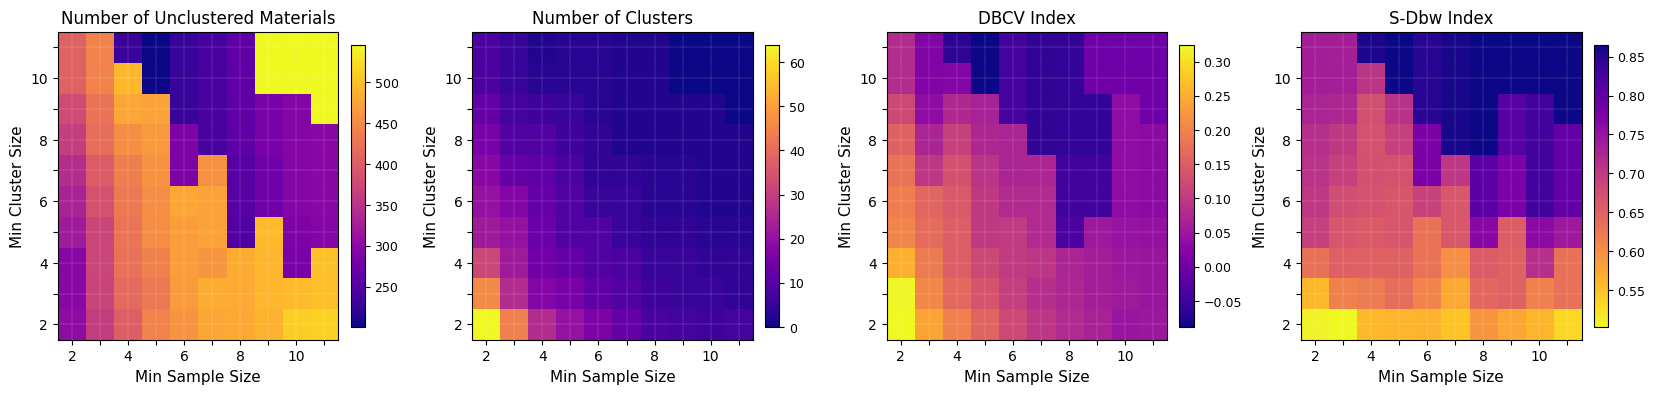

In [6]:
finite_max = np.max(s_dbw_arr[np.isfinite(s_dbw_arr)])
s_dbw_arr[np.isinf(s_dbw_arr)] = finite_max

arrays = [num_unclustered_arr, num_clusters_arr, dbcv_arr, s_dbw_arr]
cmaps = ['plasma', 'plasma', 'plasma', 'plasma_r']
titles = ["Number of Unclustered Materials", "Number of Clusters", "DBCV Index", "S-Dbw Index"]

row_labels = MIN_CLUSTER_RANGE
col_labels = MIN_SAMPLE_RANGE


fig, axes = plt.subplots(1, len(arrays), figsize=(20, 4), constrained_layout=False)

for ax, arr, title, cmap in zip(axes, arrays, titles, cmaps):
    im = ax.imshow(arr, aspect='auto', cmap=cmap, origin="lower")

    ax.set_title(title, fontsize=12, pad=6)

    # X ticks (alternate)
    ax.set_xticks(np.arange(len(col_labels)))
    xtick_labels = [str(val) if i % 2 == 0 else "" for i, val in enumerate(col_labels)]
    ax.set_xticklabels(xtick_labels, fontsize=10)

    # Y ticks (alternate)
    ax.set_yticks(np.arange(len(row_labels)))
    ytick_labels = [str(val) if i % 2 == 0 else "" for i, val in enumerate(row_labels)]
    ax.set_yticklabels(ytick_labels, fontsize=10)

    ax.set_xlabel('Min Sample Size', fontsize=11)
    ax.set_ylabel('Min Cluster Size', fontsize=11)

    ax.grid(color='white', linestyle='--', linewidth=0.3, alpha=0.5)

    cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.ax.tick_params(labelsize=9)
plt.subplots_adjust(
    wspace = 0.35,   # the amount of width reserved for blank space between subplots
) 
fig.savefig("../Figures/BestModelHeatmap.png", dpi=300, bbox_inches='tight')


## Part 4: Creating Plots of Different Clusters

/home/justin/miniconda3/envs/myenv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/justin/miniconda3/envs/myenv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/justin/miniconda3/envs/myenv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/justin/miniconda3/envs/myenv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/justin/miniconda3/envs/myenv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_

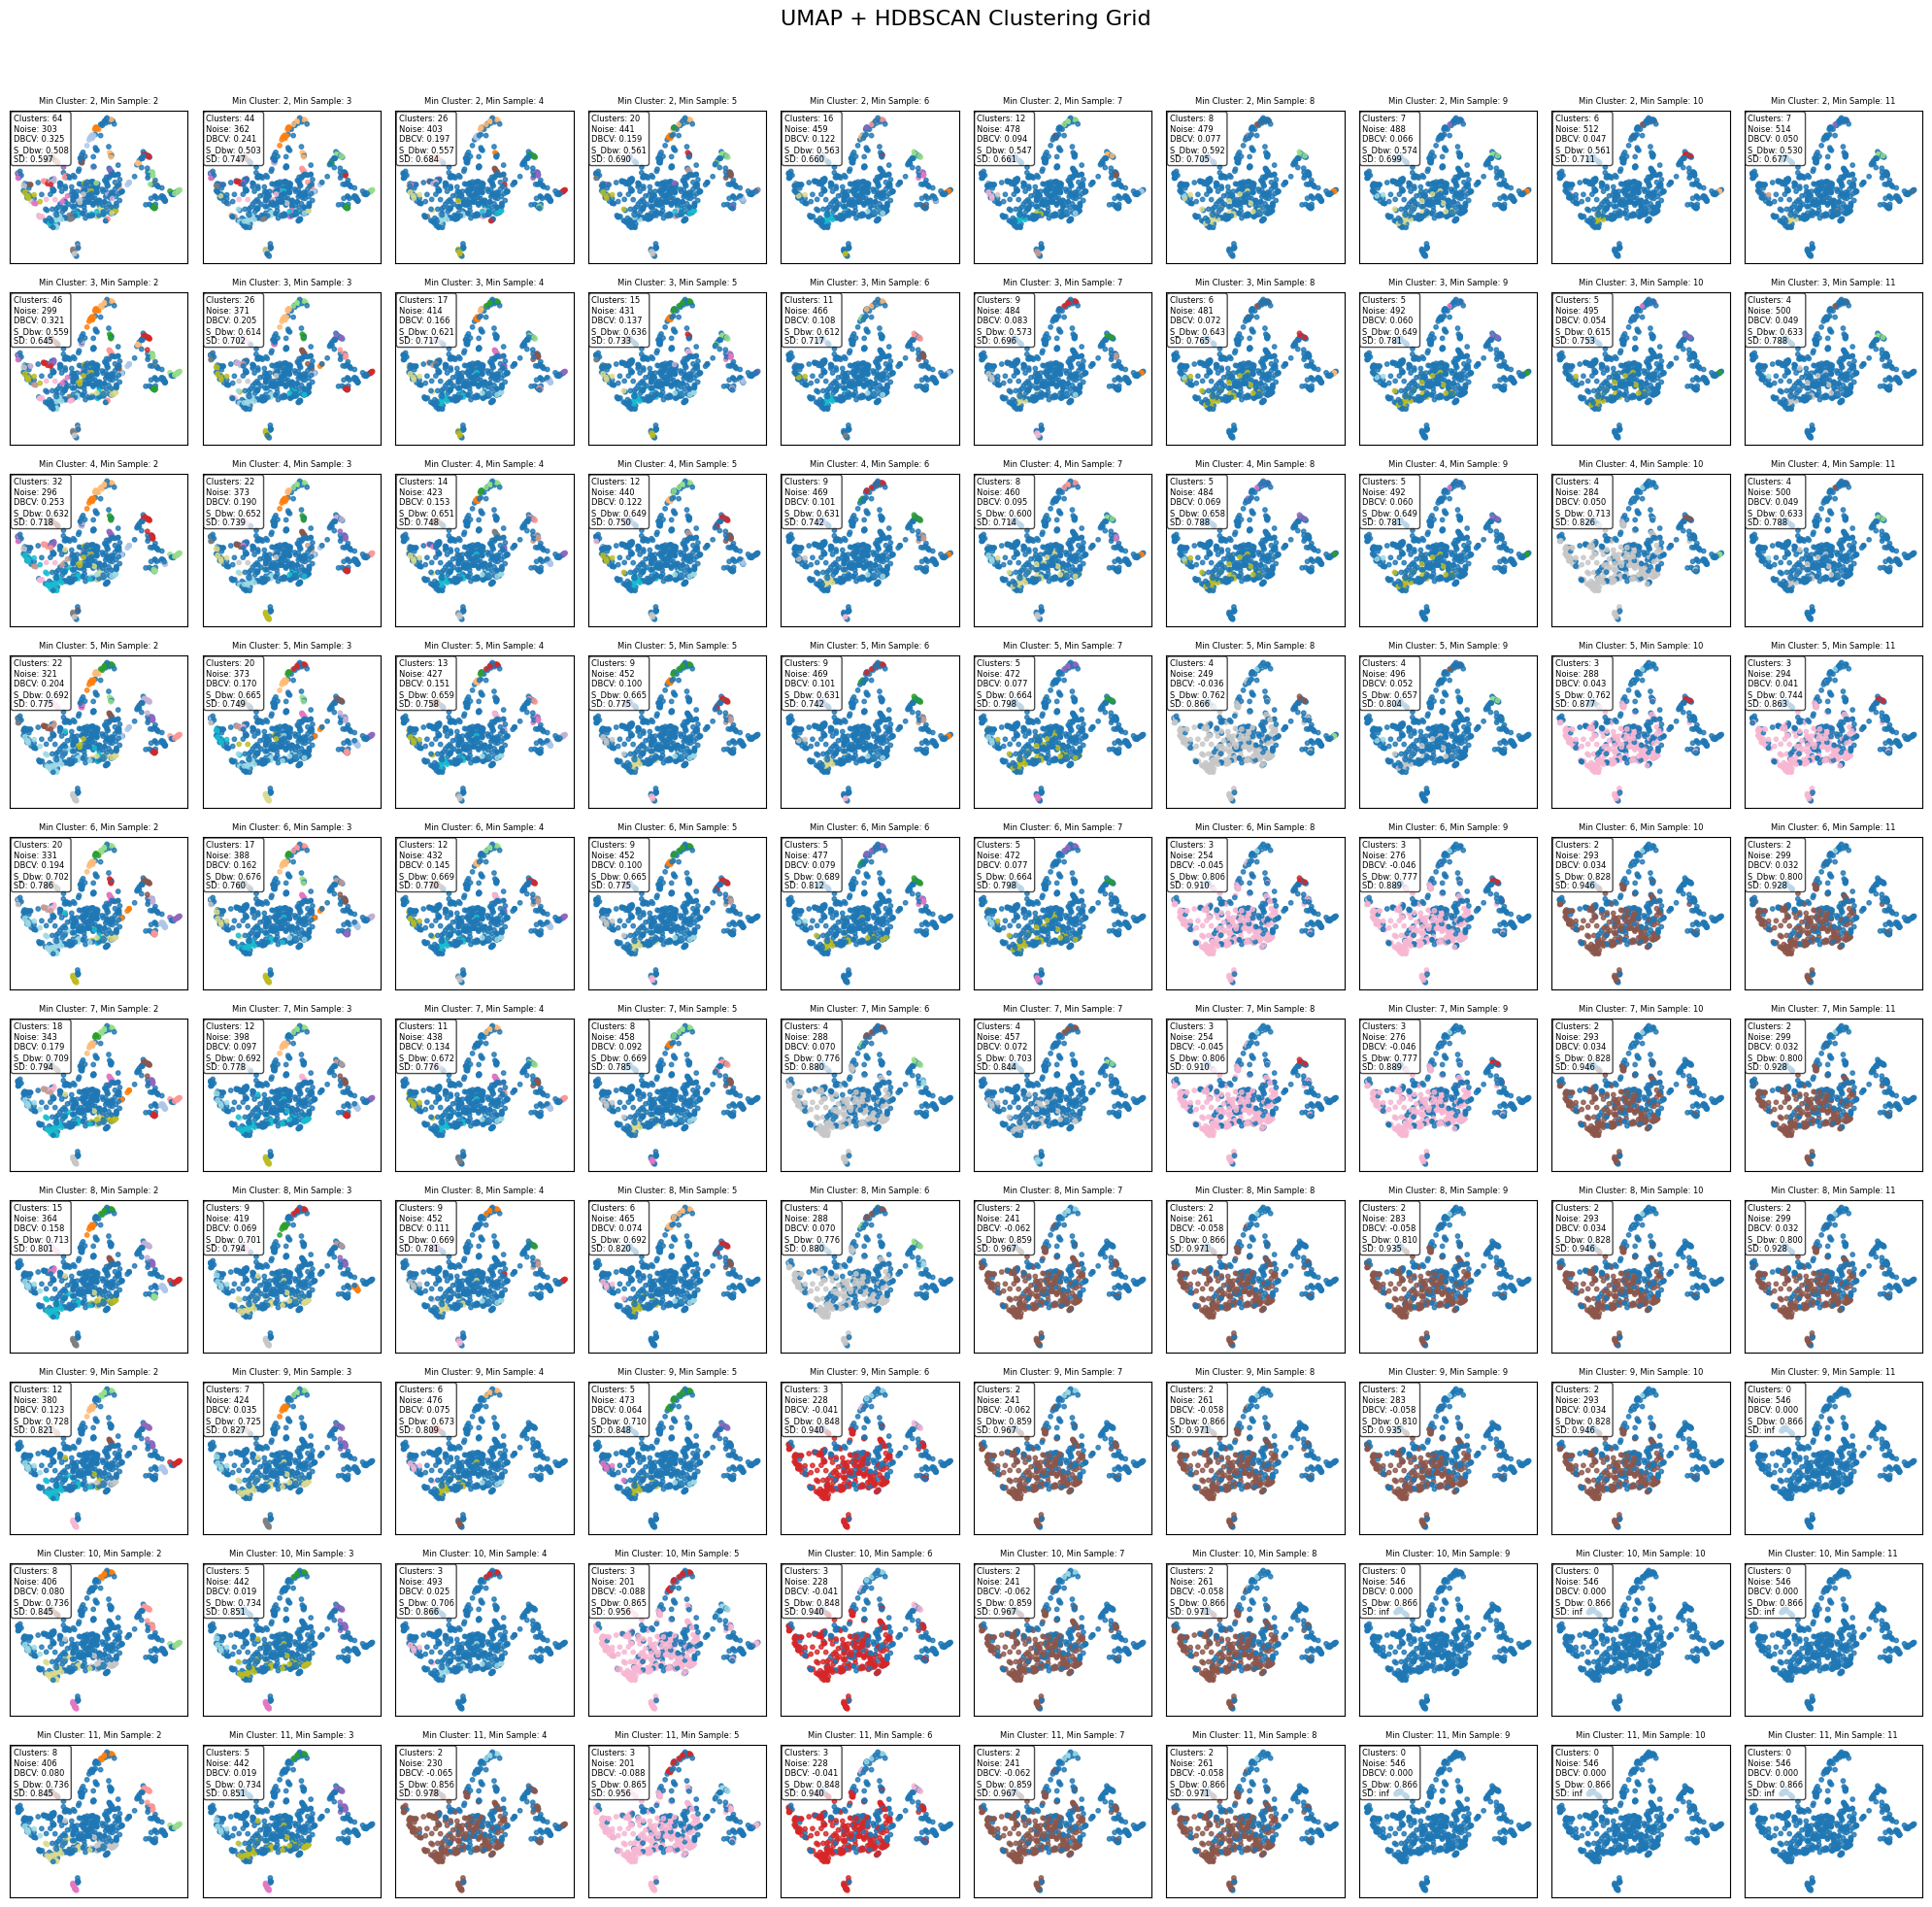

In [7]:
fig, axes = plt.subplots(len(MIN_CLUSTER_RANGE), len(MIN_SAMPLE_RANGE), figsize=(20, 20))
fig.suptitle("UMAP + HDBSCAN Clustering Grid", fontsize=16)

for i, cluster_size in enumerate(MIN_CLUSTER_RANGE):
    for j, sample_min in enumerate(MIN_SAMPLE_RANGE):
        clusterer = hdbscan.HDBSCAN(algorithm='best', alpha=1.0, approx_min_span_tree=True,
                                gen_min_span_tree=True, leaf_size=40, metric='minkowski', 
                                cluster_selection_method='leaf', min_cluster_size=cluster_size, min_samples=sample_min, p=0.2)
        
        labels = clusterer.fit_predict(features)

        ax = axes[i, j]
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f"Min Cluster: {cluster_size}, Min Sample: {sample_min}", fontsize=6)
        ax.scatter(embedding[:, 0], embedding[:, 1], c=labels, s=10, cmap='tab20', alpha=0.8)

        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise    = list(labels).count(-1)
        try:
            dbcv_val = dbcv_arr[i][j] 
            s_dbw_val = s_dbw_arr[i][j]
            sd = sd_arr[i][j]
            info_text = f"Clusters: {n_clusters}\nNoise: {n_noise}\nDBCV: {dbcv_val:.3f}\nS_Dbw: {s_dbw_val:.3f}\nSD: {sd:.3f}"
        except:
            info_text = f"Clusters: {n_clusters}\nNoise: {n_noise}"

        ax.text(
            0.02, 0.98,       # x, y in axes‐fraction coordinates
            info_text,        # the string to show
            transform=ax.transAxes,
            fontsize=6,
            va='top',         # vertical alignment
            ha='left',        # horizontal alignment
            bbox=dict(
                boxstyle='round,pad=0.3',
                facecolor='white',
            alpha=0.7
        ))

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()